#### Install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install packages
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.metrics import classification_report
device = 'cuda'

In [4]:
# Import dataset from = https://huggingface.co/datasets/winvoker/turkish-sentiment-analysis-dataset

train = pd.read_csv('/content/drive/MyDrive/twitter_sentiment/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/twitter_sentiment/test.csv')

In [5]:
# Concatenate train and df dataset into df
frames = [train, test]
df = pd.concat(frames)
df.shape, train.shape, df.shape

((489644, 3), (440679, 3), (489644, 3))

In [6]:
# Use only 1000 row for the first stage
df = df[:1000]

<Axes: >

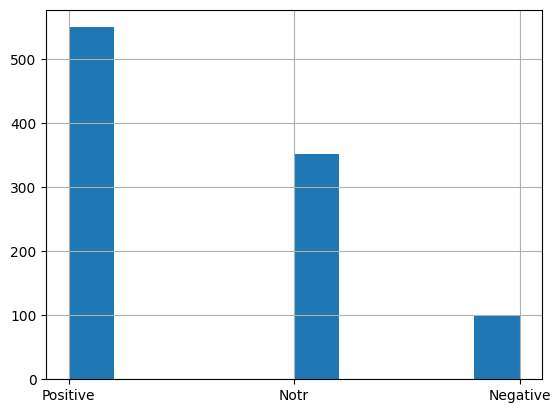

In [7]:
# Visualize the distribution of labels
df.label.hist()

In [8]:
# Converting labels to numerical value
def to_numerical(text):
  if text == 'Positive':
    return 2
  elif text == 'Negative':
    return 1
  else:
    return 0

df.label = df.label.apply(to_numerical)
df.head()

,text,label,dataset
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,2,urun_yorumlari
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",2,urun_yorumlari
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",2,urun_yorumlari
3,Çünkü aranan tapınak bu bölgededir .,0,wiki
4,bu telefonu başlıca alma nedenlerim ise elimde...,2,urun_yorumlari


In [9]:
# Train test splitting
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [10]:
# Import pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased",return_dict=False)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
train_seq.shape, train_mask.shape, train_y.shape

(torch.Size([800, 282]), torch.Size([800, 282]), torch.Size([800]))

#### Create DataLoaders

In [17]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze BERT Parameters

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Define Model Architecture

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [21]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [22]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.94562648 3.37552743 0.60744115]


In [23]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

### Fine-Tune BERT

In [24]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start Model Training

In [26]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.965
Validation Loss: 0.673

 Epoch 2 / 10

Evaluating...

Training Loss: 0.703
Validation Loss: 0.552

 Epoch 3 / 10

Evaluating...

Training Loss: 0.655
Validation Loss: 0.392

 Epoch 4 / 10

Evaluating...

Training Loss: 0.585
Validation Loss: 0.371

 Epoch 5 / 10

Evaluating...

Training Loss: 0.614
Validation Loss: 0.393

 Epoch 6 / 10

Evaluating...

Training Loss: 0.597
Validation Loss: 0.448

 Epoch 7 / 10

Evaluating...

Training Loss: 0.582
Validation Loss: 0.313

 Epoch 8 / 10

Evaluating...

Training Loss: 0.509
Validation Loss: 0.293

 Epoch 9 / 10

Evaluating...

Training Loss: 0.525
Validation Loss: 0.295

 Epoch 10 / 10

Evaluating...

Training Loss: 0.448
Validation Loss: 0.448


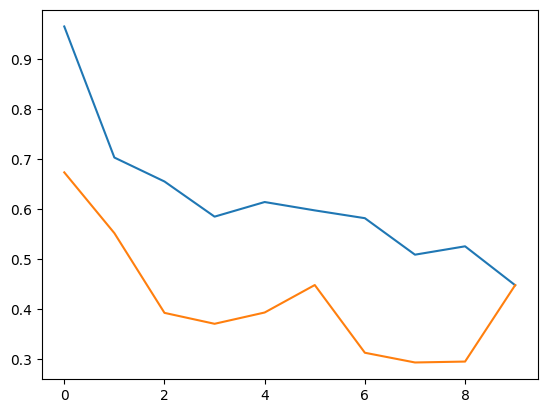

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(valid_losses)

### Load Saved Model

In [28]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Get predictions for test data

In [29]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [30]:
# model's performance
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.44      0.80      0.57        10
           2       0.96      0.82      0.88        55

    accuracy                           0.88       100
   macro avg       0.80      0.87      0.82       100
weighted avg       0.92      0.88      0.89       100



In [31]:
test_seq.shape, preds.shape

(torch.Size([100, 208]), (100,))

In [32]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2
row_0,,,
0,35,0,0
1,0,8,2
2,0,10,45


### Define pred function

In [33]:
# Define prediction function
text = 'Seni çok seviyorum'

tokenized = tokenizer.encode_plus(
    text,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

seq = torch.tensor(input_ids)
mask = torch.tensor(attention_mask)
seq = seq.unsqueeze(0)
mask = mask.unsqueeze(0)
preds = model(seq.to(device), mask.to(device))
preds = preds.detach().cpu().numpy()
result = np.argmax(preds, axis=1)
preds = torch.tensor(preds)
probabilities = nn.functional.softmax(preds)
print(result)
print(probabilities[0])

[2]
tensor([0.0549, 0.3867, 0.5584])


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-33-3e375dcd7c7b>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


In [37]:
# Define predict function (2=>POSITIVE 1=>NEGATIVE 0=>NEUTRAL)
def predict_sentiment(text):
  tokenized = tokenizer.encode_plus(
    text,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']

  seq = torch.tensor(input_ids)
  mask = torch.tensor(attention_mask)
  seq = seq.unsqueeze(0)
  mask = mask.unsqueeze(0)
  preds = model(seq.to(device), mask.to(device))
  preds = preds.detach().cpu().numpy()
  result = np.argmax(preds, axis=1)
  preds = torch.tensor(preds)
  probabilities = nn.functional.softmax(preds)

  '''return {'POSITIVE':float(probabilities[0][2]),
          'NEGATIVE':float(probabilities[0][1]),
          'NEUTRAL':float(probabilities[0][0])}
  '''
  if result == 2:
    return {'Label':'POSITIVE', 'Ratio':float(probabilities[0][2])}
  elif result == 1:
    return {'Label':'NEGATIVE', 'Ratio':float(probabilities[0][1])}
  else:
    return {'Label':'NEUTRAL', 'Ratio':float(probabilities[0][0])}
  

In [53]:
predict_sentiment('Bugün ne kadar güzel bir gün :D')

<ipython-input-37-b13a7b9a5f83>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


{'Label': 'POSITIVE', 'Ratio': 0.8757703900337219}

### Taking User Feedback